In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import pywt
import re

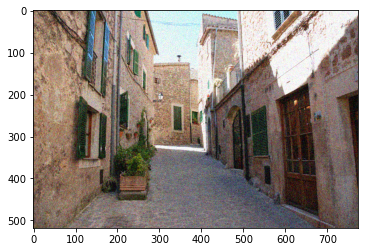

In [2]:
img = plt.imread('FFDNET_IPOL/noisy.png')
plt.imshow(img)
plt.show()

In [3]:

N1, N2 = 10, 32

def dividing_into_patches(img):
    """Divides an input image into patches of size N1xN1"""
    n, p = img.shape[0], img.shape[1]
    patches = []
    n_10, p_10 = n//10, p//10
    for i in range(n_10+1):
        for j in range(p_10+1):
            if i < n_10 and j < p_10:
                patches.append(img[i*N1:i*N1+10, j*N1:j*N1+10, :])
            elif i == n_10 and j < p_10:
                patches.append(img[n-10:n, j*N1:j*N1+10, :])
            elif i < n_10 and j == p_10:
                patches.append(img[i*N1:i*N1+10, p-10:p, :])
            elif i == n_10 and j == p_10:
                patches.append(img[n-10:n, p-10:p, :])
    return np.array(patches) 

def similarity_matrix(patches):
    """Computes the similarity matrix between the patches
    Returns a matrix of size N1xN1"""
    size = patches.shape[0]
    similarity = np.zeros((size,size))
    sim = 0

    # similarity computed with the Frobenius norm
    # leave the 0 similarity with itself to make sure every patch will be in S
    for i in range(size):
        for j in range(size):
            sim = np.linalg.norm(patches[i] - patches[j])
            similarity[i][j] = sim
    return similarity    

def building_the_look_up_table(similarity):
    """Builds a dictionnary by taking for each patch, the
    N2 most similar patches (including itself to make sure
    that all patches are in S"""
    S = {}
    n = similarity.shape[0]
    for i in range(n):
        idx = np.argpartition(similarity[i], N2)
        S['patch ' + str(i)] = idx[:N2]
    return S

def block_matching(img):

    # Dividing image into patches
    patches = dividing_into_patches(img)

    # Computing similarity matrix
    similarity = similarity_matrix(patches)

    # Building look-up-table
    look_up_table = building_the_look_up_table(similarity)

    return patches, look_up_table

In [4]:
patches, look_up_table = block_matching(img)

In [5]:
def Gamma(q, tau):
    """Shrinkage Operator"""
    return q**3/(q**2+tau**2)

In [6]:
def building_gkj_array(patch_ind, look_up_table, patches, N1, N2):
    """For each S_j, we build a group gkj_tilde which is the 3D
    array of size N1xN1xN2 formed by stacking the blocks extracted
    from y_tilde_k"""
    gkj_tilde = np.zeros((N1,N1,N2,3))
    idx = look_up_table['patch ' + str(patch_ind)]
    for i in range(len(idx)):
        gkj_tilde[:,:,i] = patches[idx[i]]
    return gkj_tilde

In [112]:
gkj_tilde = building_gkj_array(1, look_up_table, patches, N1, N2)
print(gkj_tilde[0,0,:,0])

[0.45882353 0.52941179 0.47450981 0.64313728 0.59215689 0.65490198
 0.55686277 0.49803922 0.36862746 0.72156864 0.49019608 0.70980394
 0.61176473 0.47058824 0.72549021 0.58431375 0.58431375 0.66666669
 0.5529412  0.40392157 0.51764709 0.49411765 0.627451   0.51372552
 0.47450981 0.58431375 0.53333336 0.66274512 0.7019608  0.64313728
 0.65098041 0.42352942]


In [8]:
def transform_haar_wavelet(gkj_tilde, tau):
    """Computes gkj_hat by applying the wavelet transform,
    the shrinkage operator and the inverse wavelet transform"""
    gkj_hat = np.zeros_like(gkj_tilde)
    coeffs = pywt.wavedec2(gkj_tilde, 'haar', axes=(0, 1), level=2)
    coeffs_rec = [coeffs[0]]
    for i in range(1, len(coeffs)):
        coeffs_rec.append((Gamma(coeffs[i][0],tau),Gamma(coeffs[i][0],tau),Gamma(coeffs[i][0],tau)))
    gkj_hat = pywt.waverec2(coeffs_rec, 'haar', axes=(0, 1))
    return gkj_hat

In [113]:
tau = 7.5
gkj_hat = transform_haar_wavelet(gkj_tilde, tau)
print(gkj_hat[0,0,:,0])

[0.51541187 0.55382822 0.57935532 0.57927391 0.5938881  0.54275826
 0.54387246 0.57077762 0.56784931 0.55349979 0.55931335 0.60153726
 0.58590701 0.59117927 0.62385159 0.52083565 0.49368085 0.57329308
 0.56103258 0.49352431 0.55024503 0.49968998 0.60565544 0.51644383
 0.50071202 0.52745471 0.61102906 0.56499441 0.56914932 0.66078632
 0.59494018 0.53866592]


In [10]:
def transform_over_all_img(look_up_table,patches,tau, N1, N2):
    """Applies the haar wavelet to all the image patches"""
    n = patches.shape[0]
    transform = []
    for i in range(n):
        gkj_tilde = building_gkj_array(i, look_up_table, patches, N1, N2)
        gkj_hat = transform_haar_wavelet(gkj_tilde, tau)
        transform.append(gkj_hat)
    return np.array(transform)

In [40]:
def weight_j(patch_ind, look_up_table, patches, tau, N1, N2):
    """Computes the weight defined in the article for a given gkj_tilde"""
    gkj_tilde = building_gkj_array(patch_ind, look_up_table, patches, N1, N2)
    n, p = gkj_tilde.shape[0], gkj_tilde.shape[1]
    summing = 0
    wkj = []
    for i in range(n):
        for j in range(p):
            coeffs0 = pywt.wavedec(gkj_tilde[i,j,:,0], 'haar', level=2)
            coeffs1 = pywt.wavedec(gkj_tilde[i,j,:,1], 'haar', level=2)
            coeffs2 = pywt.wavedec(gkj_tilde[i,j,:,2], 'haar', level=2)
            for i in range(len(coeffs0)):
                summing0 = np.linalg.norm(coeffs0[i])**2
                summing1 = np.linalg.norm(coeffs1[i])**2
                summing2 = np.linalg.norm(coeffs2[i])**2
    wkj += [(summing0/(summing0+tau**2))**(-2)] + [(summing1/(summing1+tau**2))**(-2)] + [(summing2/(summing2+tau**2))**(-2)]
    return wkj

In [41]:
wkj = weight_j(1, look_up_table, patches, tau, N1, N2)
print(wkj)

[217593.42287019352, 42300.108146808016, 48302.790926319605]


In [42]:
def all_weights(look_up_table, patches, tau, N1, N2):
    """Computes all weights"""
    n = patches.shape[0]
    w = []
    for i in range(n):
        w.append(weight_j(i, look_up_table, patches, tau, N1, N2))
    return w

In [43]:
all_wkj = all_weights(look_up_table, patches, tau, N1, N2)

In [44]:
print(all_wkj[1])

[217593.42287019352, 42300.108146808016, 48302.790926319605]


In [18]:
def inverse_look_up_table(patches, look_up_table):
    """Inverses the look-up table to have access for a given patch
    to all the patches this particular patch was similar to"""
    inv = {}
    n = patches.shape[0]
    for i in range(n):
        for patch in look_up_table:
            if i in look_up_table[patch]:
                num = int(re.findall(r'\d+', patch)[0])
                if ('patch '+str(i)) in inv.keys():
                    inv['patch '+str(i)] += [(num,np.where(look_up_table[patch] == i)[0][0])]
                else: 
                    inv['patch '+str(i)] = [(num,np.where(look_up_table[patch] == i)[0][0])]
    return inv

In [19]:
inv = inverse_look_up_table(patches, look_up_table)

In [46]:
all_transforms = transform_over_all_img(look_up_table,patches,tau, N1, N2)

In [116]:
def multiply(w, matrix):
    mul = np.zeros_like(matrix)
    n, p = matrix.shape[0], matrix.shape[1]
    for i in range(n):
        for j in range(p):
            mul[i,j] = np.array([w[0]*matrix[i,j,0], w[1]*matrix[i,j,1], w[2]*matrix[i,j,2]])
    return mul

In [120]:
w = [217593.42287019352, 42300.108146808016, 48302.790926319605]
mat = patches[0]
print(mat[0,0])
print(multiply(w, mat)[0,0])

[0.44705883 0.5803922  0.09019608]
[97277.06   24550.652   4356.7227]


In [130]:
X = np.array([[[1,1,1], [1,1,1], [1,1,1]], [[1,1,1], [1,1,1], [1,1,1]], [[1,1,1], [1,1,1], [1,1,5]]])
print(X.shape)
w = [1,2,3]
print(X/w)

(3, 3, 3)
[[[1.         0.5        0.33333333]
  [1.         0.5        0.33333333]
  [1.         0.5        0.33333333]]

 [[1.         0.5        0.33333333]
  [1.         0.5        0.33333333]
  [1.         0.5        0.33333333]]

 [[1.         0.5        0.33333333]
  [1.         0.5        0.33333333]
  [1.         0.5        1.66666667]]]


In [124]:
def new_patches(look_up_table, inv, patches, tau, N1, N2, all_transforms, weights):
    """Computes the new patches using the found weights and gkj_hats"""
    new_patches = []
    for patch in inv:
        summing = np.zeros((N1,N1,3))
        normalization = np.zeros((N1,3))
        for pat in inv[patch]:
            (ind_patch, position) = pat
            new_patch = all_transforms[ind_patch,:,:,position]
            # summing += multiply(weights[ind_patch],new_patch)
            summing += weights[ind_patch]*new_patch
            normalization += np.array([weights[ind_patch][0], weights[ind_patch][1], weights[ind_patch][2]])
        new_patches.append(summing / normalization)
    return np.array(new_patches)

In [141]:
new_patch = new_patches(look_up_table, inv, patches, tau, N1, N2, all_transforms, all_wkj)

In [143]:
print(new_patch.shape)

(4056, 10, 10, 3)


In [90]:
def image_estimate(new_patches, img, N1):
    """Computes the denoised image thanks to the new computed patches"""
    n, p = img.shape[0], img.shape[1]
    new_image = np.zeros((n, p, 3))
    n_10, p_10 = n//10, p//10
    cpt = 0
    for i in range(n_10+1):
        for j in range(p_10+1):
            if i < n_10 and j < p_10:
                new_image[i*N1:i*N1+N1, j*N1:j*N1+N1] = new_patches[cpt]
            elif i == n_10 and j < p_10:
                new_image[i*N1:n, j*N1:j*N1+N1] = new_patches[cpt][N1-(n-i*N1):,:]
            elif i < n_10 and j == p_10:
                new_image[i*N1:i*N1+N1, j*N1:p] = new_patches[cpt][:,N1-(p-j*N1):]
            elif i == n_10 and j == p_10:
                new_image[i*N1:n, j*N1:p] = new_patches[cpt][N1-(n-i*N1):,N1-(p-j*N1):]
            cpt += 1
    return np.clip(new_image, 0, 1)

In [97]:
new_img = image_estimate(new_patch, img, N1)

In [144]:
print(new_img[0,0])
print(img[0,0])
img_clean = plt.imread('FFDNET_IPOL/input.png')
print(img_clean[0,0])

[0.49192793 0.42862998 0.30777515]
[0.44705883 0.5803922  0.09019608]
[0.4862745  0.3764706  0.30588236]


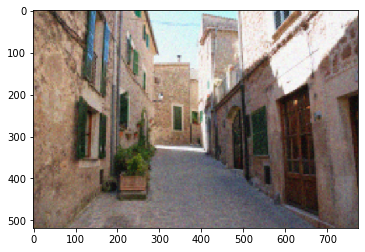

<Figure size 432x288 with 0 Axes>

In [104]:
plt.imshow(new_img)
plt.show()

In [109]:
print(new_img[0:10,0,0])

[0.49192793 0.49192265 0.49157774 0.49201771 0.47931983 0.47909016
 0.47917206 0.47917338 0.56568315 0.56568734]
